# Gradient Bandits

Hasta ahora venimos eligiendo acciones en función del valor que vamos asignando a cada una de ellas. Pero, ¿qué pasa si no conocemos el valor de las acciones? En ese caso, podemos utilizar un método de aprendizaje por gradiente.

En este caso, en lugar de asignar valores a las acciones, asignamos preferencias. La probabilidad de elegir una acción es proporcional a su preferencia. A medida que vamos obteniendo recompensas, actualizamos las preferencias de las acciones.

En este notebook vamos a implementar un agente que utiliza el método de gradiente para elegir acciones.

El algoritmo es el siguiente:

1. Inicializamos las preferencias de las acciones a 0, las llamamos $H$.
2. Calculamos la probabilidad de elegir cada acción como la exponencial de su preferencia dividida por la suma de las exponenciales de todas las preferencias. La cuenta es la siguiente:

$$\pi(a) = \frac{e^{H(a)}}{\sum_{b=1}^{k} e^{H(b)}}$$

3. Elegimos una acción en función de las probabilidades calculadas, es decir, elegimos la acción $a$ con probabilidad $\pi(a)$.

4. Actualizamos las preferencias de las acciones en función de la recompensa obtenida. La actualización es la siguiente:

$$H_{t+1}(a) = H_t(a) + \alpha (R_t - \bar{R}_t)(1 - \pi(a))$$

donde $A_t = a$ es la acción elegida en el paso $t$, $R_t$ es la recompensa obtenida en el paso $t$, y $\bar{R}_t$ es la recompensa promedio en el paso $t$. Para el resto de las acciones $b$:

$$H_{t+1}(b) = H_t(b) - \alpha (R_t - \bar{R}_t)\pi(b)$$

## Experimento

Si en lugar de que $\bar{R}_t$ sea la recompensa promedio, lo reemplazamos directamente por 0 podemos ver cómo la performance del agente empeora. A $\bar{R}_t$ se le llama *baseline* y cuando es 0 decimos que el agente no tiene *baseline*.

El experimento consistirá en comparar en un 10-armed bandit donde la recompensa promedio en cada máquina es seleccionada de una distribución normal con media 4 y desviación estándar 1 un agente que implemente gradient bandit sin baseline y otro con baseline.

In [19]:
from tabular_solutions import armed_bandit
from tabular_solutions.experiments import n_armed_bandit_experiment
import numpy as np

In [20]:
def execute_task(agent_class, env_class, steps, agent_params):
    n = 10
    mean_rewards = np.zeros(n) * 4
    std_rewards = np.ones(n)
    rewards = np.random.normal(mean_rewards, std_rewards)
    noise = 1

    env = env_class(n, rewards=rewards, noise=noise, steps_to_change=100)
    agent : armed_bandit.Agent = agent_class(env, **agent_params)

    rewards_by_step = np.zeros(steps)
    optimal_action_chosen_by_step = np.zeros(steps)

    for step in range(steps):
        optimal_action = np.argmax(env.rewards)
        agent.task(1)
        rewards_by_step[step] = agent.rewards[-1]
        optimal_action_chosen_by_step[step] = env.last_action == optimal_action

    return rewards_by_step, optimal_action_chosen_by_step

In [21]:
agents_epsilons = [0.1]
steps = 1000
tasks_qty = 2000

params = {
    'agent_class': armed_bandit.GradientBanditAgent,
    'env_class': armed_bandit.NArmedBandit,
    'steps': steps,
    'agent_params' : {
        'alpha': 0.1,
        'baseline': True,
    }
}

gradient_bandit_1_avg_reward_by_step, gradient_bandit_1_optimal_action_chosen_by_step = (
    n_armed_bandit_experiment(
        agents_epsilons,
        steps,
        tasks_qty,
        execute_task_func=execute_task,
        execute_task_params=params
    )
)

Experiment took 2.62 minutes


In [22]:
agents_epsilons = [0.1]
steps = 1000
tasks_qty = 2000

params = {
    'agent_class': armed_bandit.GradientBanditAgent,
    'env_class': armed_bandit.NArmedBandit,
    'steps': steps,
    'agent_params' : {
        'alpha': 0.1,
        'baseline': False,
    }
}

gradient_bandit_2_avg_reward_by_step, gradient_bandit_2_optimal_action_chosen_by_step = (
    n_armed_bandit_experiment(
        agents_epsilons,
        steps,
        tasks_qty,
        execute_task_func=execute_task,
        execute_task_params=params
    )
)

Experiment took 3.23 minutes


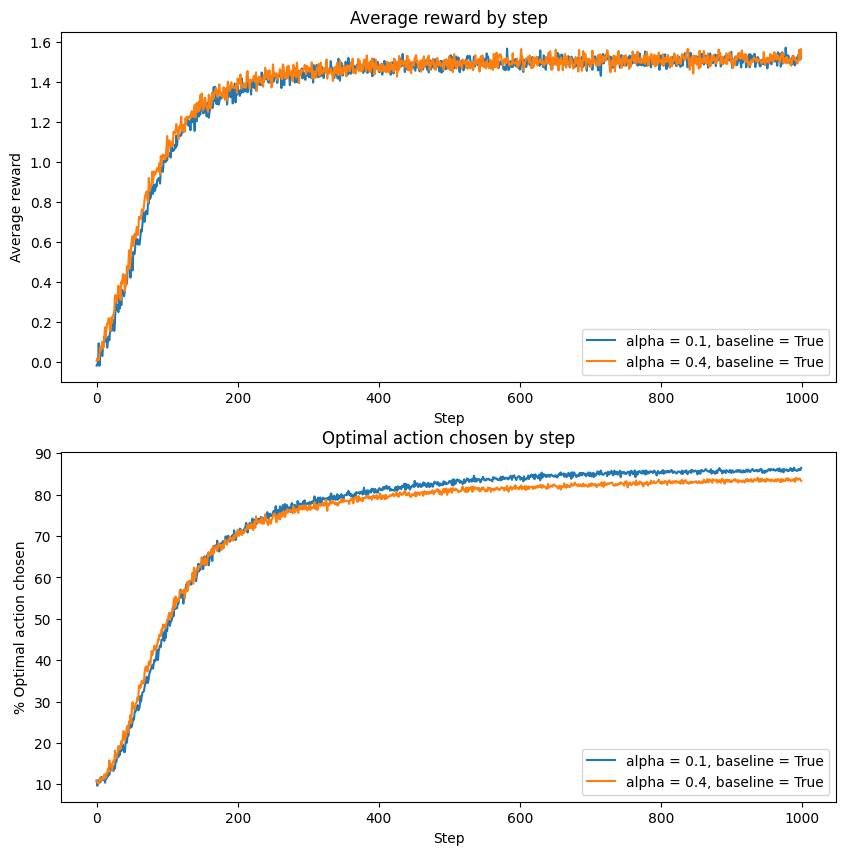

In [23]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

label_0 = f'alpha = 0.1, baseline = True'
label_1 = f'alpha = 0.4, baseline = True'
label_2 = f'alpha = 0.1, baseline = False'
label_3 = f'alpha = 0.4, baseline = False'

ax[0].plot(gradient_bandit_1_avg_reward_by_step[0], label=label_0)
ax[0].plot(gradient_bandit_2_avg_reward_by_step[0], label=label_1)

ax[1].plot(gradient_bandit_1_optimal_action_chosen_by_step[0] * 100, label=label_0)
ax[1].plot(gradient_bandit_2_optimal_action_chosen_by_step[0] * 100, label=label_1)

ax[0].set_title('Average reward by step')
ax[0].set_xlabel('Step')
ax[0].set_ylabel('Average reward')
ax[0].legend()

ax[1].set_title('Optimal action chosen by step')
ax[1].set_xlabel('Step')
ax[1].set_ylabel('% Optimal action chosen')
ax[1].legend()

plt.show()

# Resultados

El agente con baseline tiene una performance mucho mejor que el agente sin baseline en la elección de la acción óptima.
